# Street dataset

Show how good is plate detection on images taken on the street.

In [63]:
%matplotlib inline
import random
import time
import numpy as np
import pandas as pd
from skimage import io
from skimage.color import rgb2grey
from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
from pylab import rcParams

TEST_PATH = '../../data/street/'
MODEL_PATH = '../../model/artificial'

## Import data

Data is stored in csv file. Images are saved as PNG files.

Data will be loaded into the following variables:
  * X - Images, (num_of_images, image_height, image_width) Tensor
  * Y - Labels, (num_of_images, 4) left, top, right, bottom 

In [87]:
def load_image(fname):
    img = rgb2grey(io.imread(fname)) / 256.
    i = 512
    j = img.shape[1] - 100
    img2 = img[-i:, j:-j]
    return rescale(img, (.25, .25))

df_test = pd.read_csv(TEST_PATH + 'plates.csv')
xs = [load_image(TEST_PATH + fname) for fname in df_test['image']]
x_test = np.array(xs)
y_test = df_test[['left', 'top', 'right', 'bottom']].as_matrix()
print('Test images shape: ' + str(x_test.shape))
print('Test labels shape: ' + str(y_test.shape))

Test images shape: (24, 150, 200)
Test labels shape: (24, 4)


### Show sample images

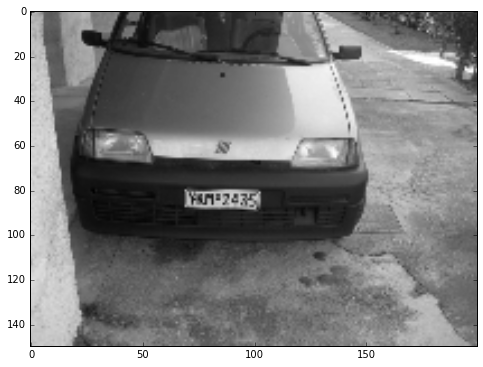

In [94]:
rcParams['figure.figsize'] = 8, 12
plt.gray()
plt.imshow(x_test[random.randint(0, x_test.shape[0]-1)])

## Build Tensorflow neural net

### Load model

In [5]:
# %load ../script/klangner/artificial.py
import tensorflow as tf

PIXEL_COUNT = 64 * 128
LABEL_COUNT = 4


class CNN:

    def __init__(self, ):
        self.x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])

    def build(self):
        x_image = tf.reshape(self.x_placeholder, [-1, 64, 128, 1])
        # Convolution Layer 1
        W_conv1 = self.weight_variable([3, 3, 1, 32])
        b_conv1 = self.bias_variable([32])
        h_conv1 = tf.nn.relu(self.conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = self.max_pool_2x2(h_conv1)
        # Convolution Layer 2
        W_conv2 = self.weight_variable([2, 2, 32, 64])
        b_conv2 = self.bias_variable([64])
        h_conv2 = tf.nn.relu(self.conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = self.max_pool_2x2(h_conv2)
        # Convolution Layer 3
        W_conv3 = self.weight_variable([2, 2, 64, 128])
        b_conv3 = self.bias_variable([128])
        h_conv3 = tf.nn.relu(self.conv2d(h_pool2, W_conv3) + b_conv3)
        h_pool3 = self.max_pool_2x2(h_conv3)
        # Dense layer 1
        h_pool3_flat = tf.reshape(h_pool3, [-1, 8*16*128])
        W_fc1 = self.weight_variable([8*16*128, 500])
        b_fc1 = self.bias_variable([500])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
        # Dense layer 2
        W_fc2 = self.weight_variable([500, 500])
        b_fc2 = self.bias_variable([500])
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
        # Output layer
        W_out = self.weight_variable([500, LABEL_COUNT])
        b_out = self.bias_variable([LABEL_COUNT])
        return tf.matmul(h_fc2, W_out) + b_out

    @staticmethod
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    @staticmethod
    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    @staticmethod
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    @staticmethod
    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### Show predictions

In [6]:
neural_net = CNN()
model = neural_net.build()

def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='b', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    plt.scatter(x=labels[0], y=labels[1], marker='x', color='r')
    
def plot_images(images, labels):
    rows = int(images.shape[0] / 3)
    rcParams['figure.figsize'] = 18, 1.5*images.shape[0]
    plt.gray()
    fig = plt.figure()
    for i in range(min(30, images.shape[0])):
        fig.add_subplot(rows, 3, i+1)
        show_image(images[i], labels[i])
    plt.show()   

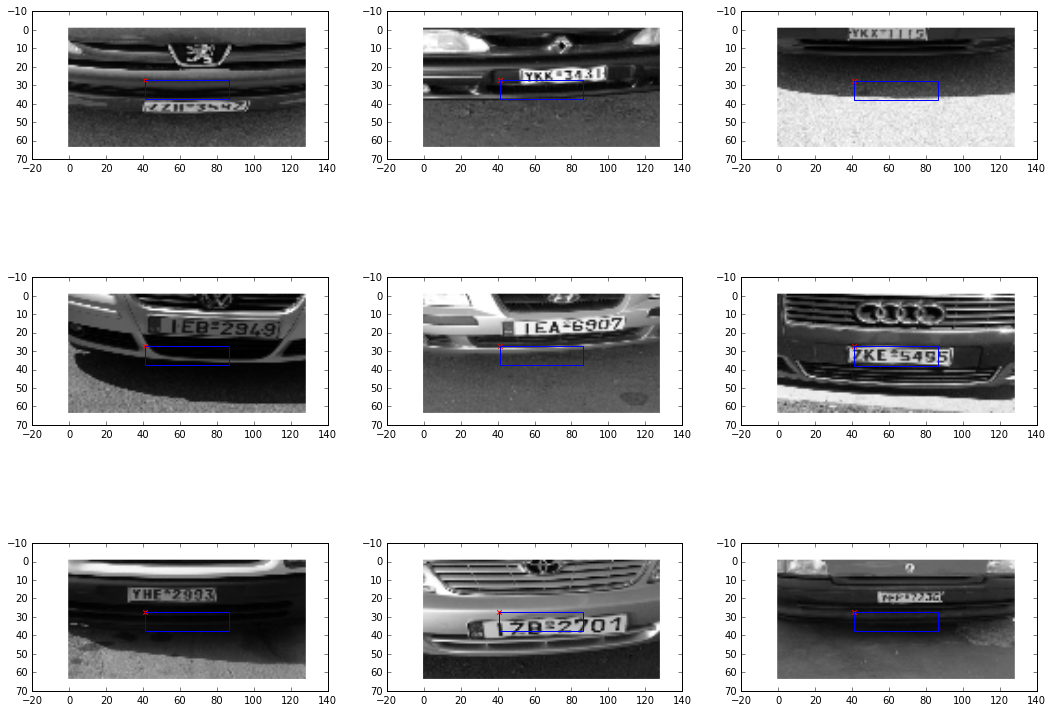

In [32]:
x2_test = np.reshape(x_test[:9], (9, x_test.shape[1]*x_test.shape[2]))
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, MODEL_PATH)
    y2_test = model.eval(feed_dict={neural_net.x_placeholder: x2_test})
    plot_images(x_test[:9], (y2_test+1) * (64, 32, 64, 32))